

```
# num=0; for i in *; do mv "$i" "$(printf '%04d' $num).${i#*.}"; ((num++)); done
```

# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [2]:
from google.colab import drive
import os

In [3]:
drive.mount._DEBUG = True
drive.mount('/content/gdrive/', force_remount=True)

unset HISTFILE; export PS1="root@9359b7f40b25-3de42b26e6c2425caeebac3811b64497: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@9359b7f40b25-3de42b26e6c2425caeebac3811b64497: umount -f /content/gdrive/ || umount /content/gdrive/; pkill -9 -x drive
umount: /content/gdrive/: no mount point specified.
umount: /content/gdrive/: no mount point specified.
root@9359b7f40b25-3de42b26e6c2425caeebac3811b64497: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@9359b7f40b25-3de42b26e6c2425caeebac3811b64497: ( while `sleep 0.5`; do if [[ -d "/content/gdrive/" && "$(ls -A /content/gdrive/)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 93
root@9359b7f40b25-3de42b26e6c2425caeebac3811b64497: cat /tmp/tmpxhraytxh/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_

In [4]:
!cp '/content/gdrive/MyDrive/data.zip' data.zip

In [5]:
os.makedirs("celeba_gan/1")

with ZipFile("data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan/1")


In [ ]:
#!for f in '/content/leba_gan/*'; do mv $f ${f#??}; done
#!pwd


#!rename /content/leba_gan/'s/cs//' /content/leba_gan/'*.png'



In [ ]:
#!cd leba_gan/ & !ls


Create a dataset from our folder, and rescale the images to the [0-1] range:

In [6]:
dataset = dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
    )
dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 1 classes.


Let's display a sample image:

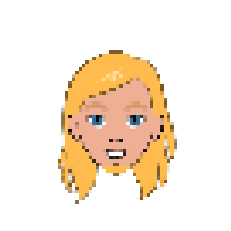

In [7]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [8]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [9]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

## Override `train_step`

In [10]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [11]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/gdrive/MyDrive/Brief15/generated_img_%03d_%d.png" % (epoch, i))
            

## Train the end-to-end model

In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.built=True
gan.load_weights("/content/gdrive/MyDrive/Brief15/saved.h5") #restart from previouly saved weights

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
313/313 [==============================] - 164s 402ms/step - d_loss: 0.1395 - g_loss: 10.1573
Epoch 2/100
313/313 [==============================] - 131s 416ms/step - d_loss: 0.0404 - g_loss: 7.5602
Epoch 3/100
313/313 [==============================] - 131s 415ms/step - d_loss: 0.0134 - g_loss: 10.8812
Epoch 4/100
313/313 [==============================] - 131s 416ms/step - d_loss: 0.1486 - g_loss: 11.8019
Epoch 5/100
313/313 [==============================] - 131s 416ms/step - d_loss: 0.4066 - g_loss: 2.3077
Epoch 6/100
313/313 [==============================] - 131s 415ms/step - d_loss: 0.2220 - g_loss: 2.1735
Epoch 7/100
313/313 [==============================] - 130s 414ms/step - d_loss: 0.3557 - g_loss: 1.6467
Epoch 8/100
313/313 [==============================] - 131s 415ms/step - d_loss: 0.6317 - g_loss: 1.0714
Epoch 9/100
313/313 [==============================] - 131s 414ms/step - d_loss: 0.7294 - g_loss: 0.9173
Epoch 10/100
313/313 [==============================

In [ ]:
history.history.keys()

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-1]
plt.show()

In [ ]:
gan.save_weights("/content/gdrive/MyDrive/Brief15/saved.h5")

In [ ]:
import IPython.display as display
from PIL import Image

for i in range(10):
  image_path = '/content/gdrive/MyDrive/Brief15/generated_img_005_'+str(i)+'.png'
  display.display(Image.open(image_path))

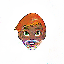

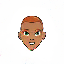

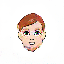

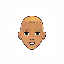

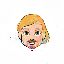

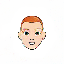

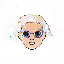

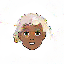

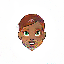

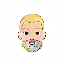